## Simulating at higher temperatures and setting $Q_{10}$ values

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 2000)
pd.set_option("display.float_format", "{:,.4f}".format)

In [3]:
from pyloric import create_prior, simulate, stats
from pyloric.utils import show_traces, energy_of_membrane, energy_of_synapse
import torch

### Create prior

In [4]:
prior = create_prior()
_ = torch.manual_seed(2)
p = prior.sample((1,))
p

AB/PD                                                           LP                                                           PY                                                     Synapses                                                     
        Na    CaT    CaS       A     KCa      Kd      H   Leak       Na    CaT    CaS       A    KCa       Kd      H   Leak       Na    CaT    CaS       A    KCa       Kd      H   Leak    AB-LP    PD-LP   AB-PY    PD-PY    LP-PD    LP-PY    PY-LP
0 458.7803 0.7269 5.6700 32.4157 13.6989 90.7140 0.0024 0.0027 138.5559 1.1557 2.8209 44.1501 6.1972 100.9982 0.0440 0.0210 564.8376 2.4631 3.0317 33.4177 3.7200 120.6760 0.0477 0.0278 -12.5681 -16.8734 -8.3747 -18.1356 -16.2665 -13.3063 -18.0895

### Simulate and keep track of energy consumption

In [5]:
simulation_output = simulate(p.loc[0], track_energy=True, seed=1)

### Visualize voltage trace

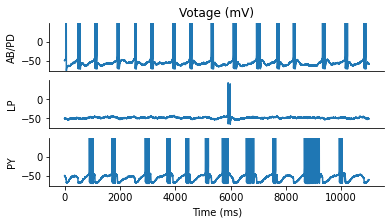

In [6]:
_ = show_traces(simulation_output)

### Visualize energy consumption

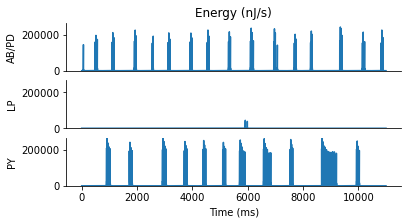

In [7]:
_ = show_traces(simulation_output, key='energy')

### Simulate again. This time, track all conductances.

In [8]:
simulation_output = simulate(p.loc[0], track_currents=True, track_energy=True, seed=1)

In [9]:
membrane_conductances = simulation_output['membrane_conds']
synaptic_conductances = simulation_output['synaptic_conds']
reversal_calcium = simulation_output['reversal_calcium']

print('Shape of membrane_conductances', membrane_conductances.shape)
print('Shape of synaptic_conductances', synaptic_conductances.shape)
print('Shape of reversal_calcium', reversal_calcium.shape)

Shape of membrane_conductances (3, 8, 440000)
Shape of synaptic_conductances (7, 440000)
Shape of reversal_calcium (3, 440000)


### Calculate the energy per second of each current
$W(t) = I \cdot U = g \cdot (V - V_{\text{rev}})^2 = \text{... nJ/s}$

In [10]:
# Reversal potentials.
v_r_na = 50
v_r_k = -80
v_r_h = -20
v_r_leak = -50
voltage = simulation_output['voltage']

In [11]:
E_na = membrane_conductances[:, 0, :] * (voltage - v_r_na)**2

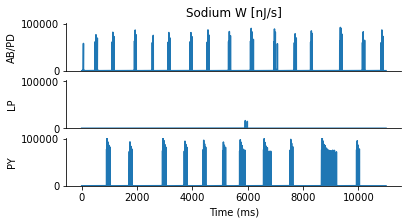

In [12]:
_ = show_traces(simulation_output, traces=E_na, title='Sodium W [nJ/s]')

### Compute all other membrane currents and visualize their sum
For calcium, we have to take into account that the reversal potential varies over time. The plot looks very similar to the one above where we directly computed the energy (the above plot also includes energy consumed by the synapses).

In [13]:
E_CaS = membrane_conductances[:, 1, :] * (voltage - reversal_calcium)**2
E_CaT = membrane_conductances[:, 2, :] * (voltage - reversal_calcium)**2
E_A = membrane_conductances[:, 3, :] * (voltage - v_r_k)**2
E_KCa = membrane_conductances[:, 4, :] * (voltage - v_r_k)**2
E_Kd= membrane_conductances[:, 5, :] * (voltage - v_r_k)**2
E_H = membrane_conductances[:, 6, :] * (voltage - v_r_h)**2
E_leak = membrane_conductances[:, 7, :] * (voltage - v_r_leak)**2

summed_current = E_na + E_CaS + E_CaT + E_A + E_KCa + E_Kd + E_H + E_leak

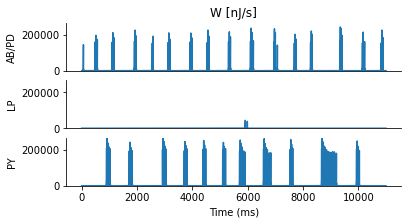

In [14]:
_ = show_traces(simulation_output, traces=summed_current, title='W [nJ/s]')

### Calculate the total energy by integrating over time
$E = \int W(t) dt \approx \sum_t W_t \cdot \Delta t = \text{... nJ}$

In [15]:
total_energy = sum(sum(summed_current)) * simulation_output['dt'] / 1000 # /1000 because of milliseconds

In [16]:
print(f"The total energy consumed with 11 seconds of simulation is:   {total_energy:.1f} nJ")

The total energy consumed with 11 seconds of simulation is:   59300.6 nJ


### Using pre-built funcitons to do the above

In [17]:
energies_per_membrane = energy_of_membrane(simulation_output)
energies_per_synapse = energy_of_synapse(simulation_output)

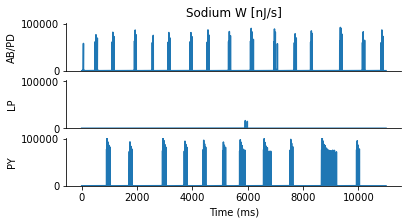

In [18]:
_ = show_traces(simulation_output, traces=energies_per_membrane[0], title='Sodium W [nJ/s]')